### Een eenvoudig lineair model

Nu we de data beschikbaar hebben kunnen beginnen met een eerste model te maken. Ik ga er vanuit dat dit lineaire model zeer slecht om kan gaan met deze foto's, maar het het is wel interessant om te zien wat er gebeurt. <br> 
Ook kunnen we nog wat extra visualisaties maken die meer inzicht geven in de dataset.

In [1]:
# laden van libraries

%load_ext autoreload
%autoreload 2

from pathlib import Path
import os
import sys
import tensorflow as tf

sys.path.insert(0, "..")
sys.path

# loading libraries, some settings for plots
import seaborn as sns
sns.set_theme()
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
plt.rcParams['figure.figsize'] = [10, 10]

from itertools import product



import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings("ignore", category=ConvergenceWarning)

from sklearn.linear_model import SGDClassifier
from sklearn.dummy import DummyClassifier 
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.metrics import confusion_matrix, f1_score, precision_recall_curve, roc_curve
from sklearn.model_selection import train_test_split

# directory bepalen
datadir_processed = Path("../data/processed")

# functies beschikbaar maken
from src.data import make_dataset_simple
#from src.data import data_pre
from src.visualization import visualize_simple


# Het maken van datasets
Ik maak op basis van de foto's uit de 10 verschillende subdirectories een dataset, met 10 verschillende klassen. Deze splits ik vervolgens in een trainings- en testset.
Ik kies daarbij een verhouding van 70/30. 80/20 is ook een veel gebruikte splitsing, maar met 17.000+ foto's heb ik met 70/30 ook voldoende traingsmateriaal.

In [2]:
data, labels = make_dataset_simple.data_set_maken(datadir_processed)

# train en testset maken
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.3,
                                                random_state=42)

# uitkomst checken
print(X_train.shape)
print(X_test.shape)

(12415, 64, 64)
(5321, 64, 64)


We hebben nu een trainingsset en testset bestaande uit foto's van 64x64 pixels.

# Binaire classificatie
Om eenvoudig te beginnen ga ik proberen om een binaire classificatie te doen. In dit geval kies ik voor 'Round Smooth'/ geen 'Round Smooth'. <br>
Ik ga eerst een aantal voorbeelden bekijken.

Found 17736 files belonging to 10 classes.


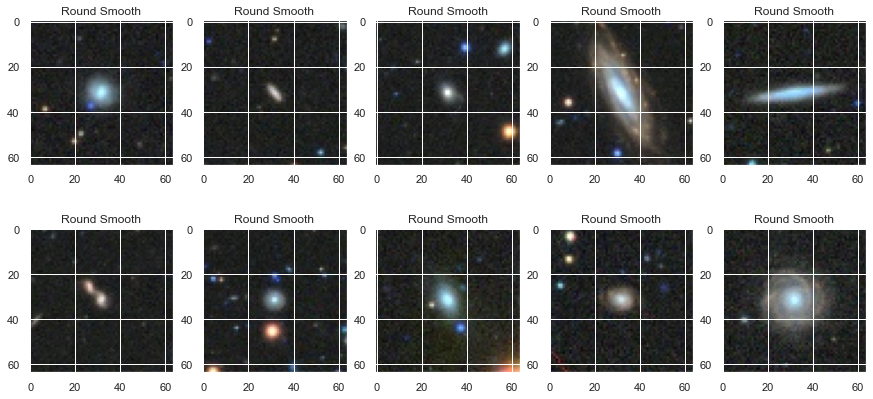

In [3]:
# print 10 foto's van een klasse
whole = tf.keras.utils.image_dataset_from_directory(
    datadir_processed, labels='inferred', label_mode='int', image_size=(64,
    64)) # dataset puur voor het tonen van foto's

class_name = 'Round Smooth'
plt.figure(figsize=(15, 7))
for i in range(10):
    filtered_whole = whole.filter(lambda x, l: tf.math.equal(l[0], i))
    for image, label in filtered_whole.take(1):
        ax = plt.subplot(2, 5, i+1)
        plt.imshow(image[0].numpy().astype('uint8'))
        plt.title(class_name)
        plt.axis('on')


Ik zie duidelijk ronde vormen in het midden, maar ook weer heel veel 'noise' er omheen.

Ik kijk vervolgens naar de verhouding tussen de 'Round Smooth' klasse en de rest.

In [4]:
# hoe groot is het aandeel van de 'Round Smooth' klasse
y_train_single, y_test_single = make_dataset_simple.set_class(y_train, y_test, cl='Round Smooth')
np.mean(y_train_single) , np.mean(y_test_single)


(0.14627466774063633, 0.15579778237173464)

Dit kan ik ook visueel maken.

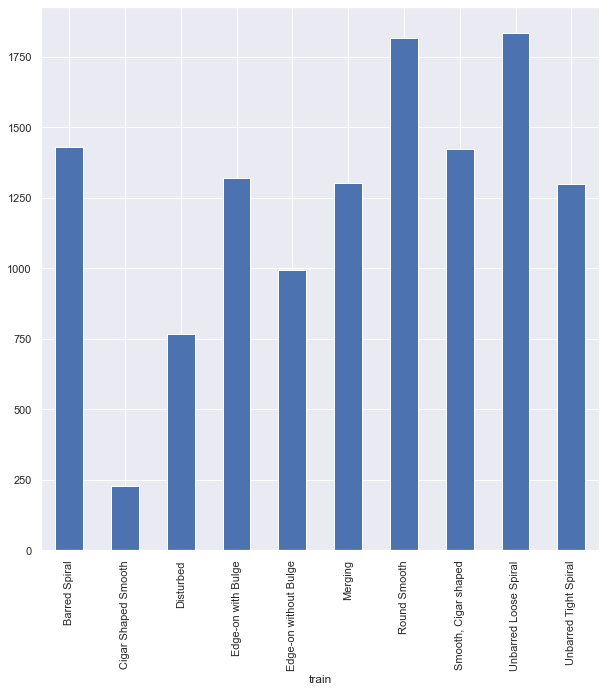

In [5]:
# aantal per klasse
visualize_simple.class_balance(y_train, 'train')


Ongeveer 15% van de gevallen is een 'Round Smooth' klasse stelsel. Nu ga ik de 64 x 64 beelden omzetten naar een vector van 4096 pixels

In [6]:
# the -1 tells the method .reshape() to reshape to a matrix where the amount that should be at -1 is deducted from the other amounts.
# because the first number is 12.415 / 5.321, reshape will make sure the second value is 4096, because that is the only way
# to make a matrix with 12.415 / 5.321 rows, in this case.

X_train = X_train.reshape(X_train.shape[0], -1)
X_test = X_test.reshape(X_test.shape[0], -1)

print(X_train.shape)
print(X_test.shape)

(12415, 4096)
(5321, 4096)


Nu kunnen we een model bouwen, in dit geval een eenvoudige SGD classifier.

In [7]:
sgd = SGDClassifier(random_state=42, max_iter=300, n_jobs=1)
sgd.fit(X_train, y_train_single)

SGDClassifier(max_iter=300, n_jobs=1, random_state=42)

# Een kijkje in het model
Ik maak een visualisatie van hoe het model gewichten toekent. Zou het model zo slim zijn om een ronde vorm in het midden meer gewicht toe te kennen?

<AxesSubplot:>

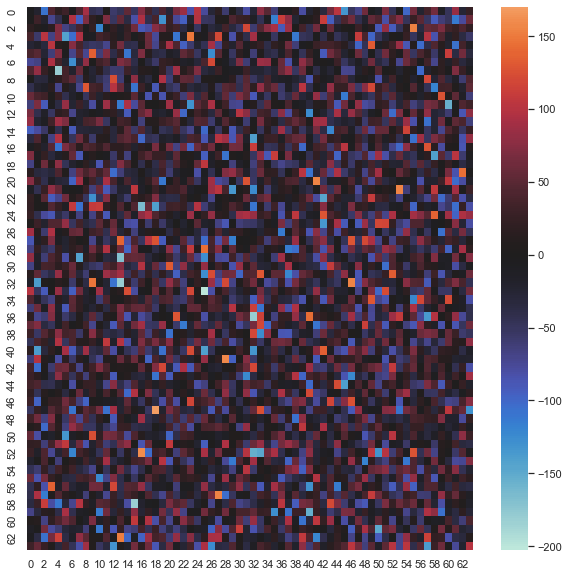

In [8]:
weights = sgd.coef_.reshape(64, 64)
sns.heatmap(weights, center = 0)

Nee, totaal niet. Dat had ik ook niet verwacht van dit eenvoudige lineaire model. Ik check nu de accuracy.

In [9]:
cross_val_score(sgd, X_train, y_train_single, cv = 3, scoring='accuracy')

array([0.79922687, 0.70952151, 0.72716288])

Dat lijkt niet eens zo slecht, maar als we dit vergelijken met een dummy classifier:

In [10]:
dummy_majority = DummyClassifier(strategy='most_frequent').fit(X_train, y_train_single)
cross_val_score(dummy_majority, X_train, y_train_single, cv = 3, scoring='accuracy')

array([0.85358782, 0.8537941 , 0.8537941 ])

Juist, die doet het nog beter. Om meer inzicht te krijgen kunnen we een Confusion Matrix maken.

f1-score = 0.17812704649639816


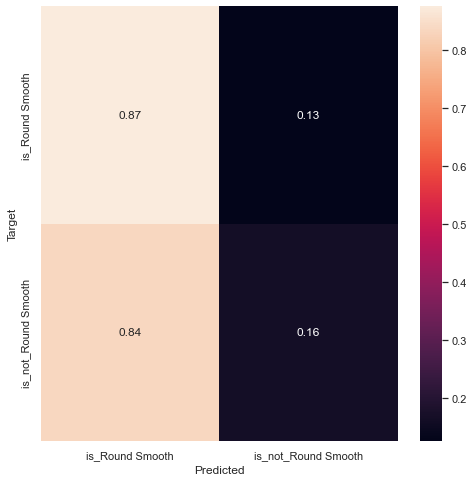

In [11]:
y_test_hat = sgd.predict(X_test)

cfm = confusion_matrix(y_test_single, y_test_hat)
visualize_simple.cfm_heatmap(cfm, scale = 'rowwise', labels=['is_Round Smooth', 'is_not_Round Smooth'])

print(f"f1-score = {f1_score(y_test_single, y_test_hat)}")

Het model voorspelt 87% van de 'Round Smooth' correct, maar voorspelt ook veel te veel van de andere klassen als 'Round Smooth'. De f1 score (het gemiddelde van de preciesie en recall) is erg laag.

Ik kijk ook naar de Precision-Recall curve om te zien hoe het model presteert

2022-02-13 12:04:37.768 | INFO     | src.visualization.visualize_simple:precision_recall_curve:71 - Found different lengths: thresholds=12400 precision=12401                 and recall=12401
2022-02-13 12:04:37.769 | INFO     | src.visualization.visualize_simple:precision_recall_curve:75 - Stripping of items after index 12400


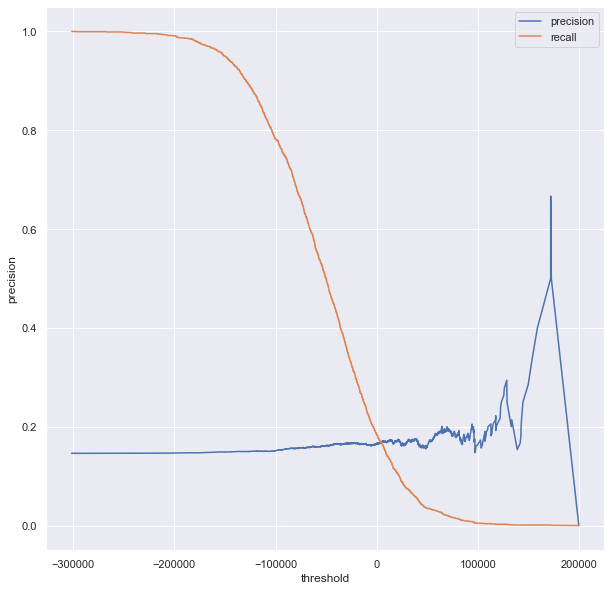

In [12]:
y_decision = cross_val_predict(sgd, X_train, y_train_single, cv = 3, n_jobs = 4, method = 'decision_function')
precision, recall, thresholds = precision_recall_curve(y_train_single, y_decision)
visualize_simple.precision_recall_curve(precision, recall, thresholds)

De Recall is nog wel redelijk, maar de Precision gaat helemaal de mist in. Tenslotte kijk ik nog naar de ROC curve.

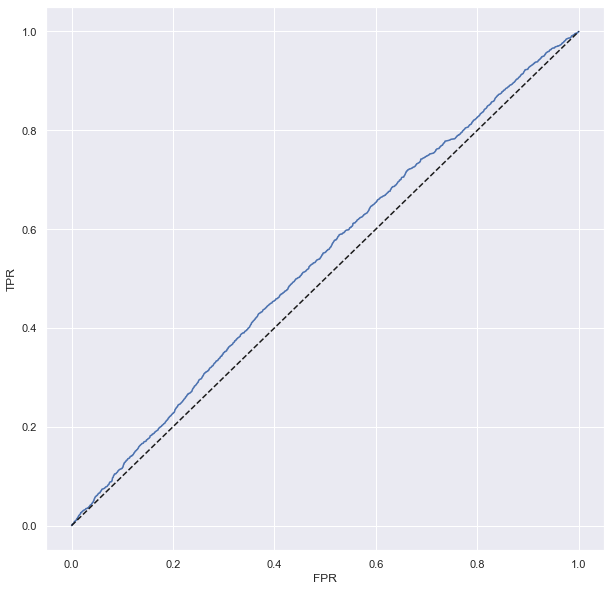

In [13]:
fpr, tpr, thresholds = roc_curve(y_train_single, y_decision)
visualize_simple.roc_curve(fpr, tpr)

Zoals te verwachten ligt de ROC curve maar net boven de baseline. Bij een goed model wil je de curve veel meer met de knik links bovenin hebben. Zowel de TPR als de FPR is niet goed.

# Multiclass
Ondanks dat de binaire classificatie niet goed is wil ik toch nog kijken naar hoe multiclass classificatie gaat. Mijn verwachtingen zijn laag.

In [14]:
# Data scalen om het model te helpen
X_scale = make_dataset_simple.scale(X_train)

2022-02-13 12:05:00.405 | INFO     | src.data.make_dataset_simple:scale:17 - Run standardscaler on data.


In [15]:
# then fit a SGD classifier 
# will take about 5 minutes

sgd = SGDClassifier(random_state=42, max_iter=1000, n_jobs=4)
yhat = cross_val_predict(sgd, X_scale, y_train, cv = 3)

Een Confusion Matrix geeft voor Multiclass een goed inzicht.

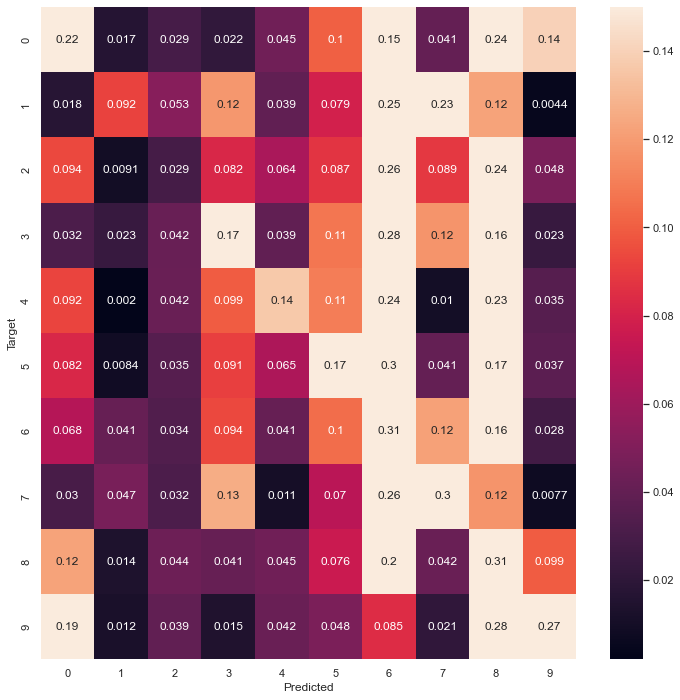

In [16]:
cfm = confusion_matrix(y_train, yhat)
visualize_simple.cfm_heatmap(cfm, figsize=(12,12), scale='rowwise', vmax= 0.15)

De hoogste scores liggen rond de 30%, maar alles bij elkaar is dit geen bruikbaar model voor deze dataset.

# Observaties en conclusies
Zoals verwacht is de dataset veel te complex voor een eenvoudig lineair model dat alle pixels op een rij zet. De volgende stap is een model dat beter kan omgaan met non-linaire data.